# Data visualization
This notebook is for visualizing the data distribution across different demographic groups to get a quick understanding of the sample population and any potential imbalances. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plot_likert
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from scripts import utils
plot_likert.__internal__.BAR_LABEL_FORMAT = "%.1f" # plotting shows % with 2 decimals

In [39]:
# Vars for plotting purposes
courses_cg = ["COMP202", "COMP250"]
courses_ee = ["COMP251", "COMP424", "COMP551"]
courses = courses_cg + courses_ee


deg_type = ["Undergraduate", "Graduate"]
years = ["U0", "U1", "U2", "U3", "U4+", "M1", "M2", "M3+", "PhD1", "PhD2", "PhD3", "PhD4", "PhD5+"]
majors = ["CS/SWE major", "CS/SWE minor", "Other"]
genders = ["Man", "Woman", "Other", "Prefer not to answer"]
minorities = ["Yes", "No", "Prefer not to answer"]
age = ["<18", "18-24", "25-34", "35-44", ">45", "Prefer not to answer"]
ethics_knowledge = ["Yes", "No"]
likert = range(1, 8)
likert_values = ["Strongly Disagree", "Disagree", "Somewhat Disagree", "Neutral", "Somewhat Agree", "Agree", "Strongly Agree"]

# current semester (for script purposes)
semester = "F2025"

In [ ]:
data_dir = os.path.join(project_root, 'data')

ee_file = "F2025_ee_clean.csv"
cg_file = "F2025_cg_clean.csv"
questions_file = f"{semester}_survey.yaml"

ee_data_path = os.path.join(data_dir, 'clean', ee_file)
cg_data_path = os.path.join(data_dir, 'clean', cg_file)

In [146]:
ee_data = pd.read_csv(ee_data_path, header=[0,1], index_col=0)
cg_data = pd.read_csv(cg_data_path, header=[0,1], index_col=0)
data_all = [ee_data, cg_data]

# rebuild the multiindexing properly to make data access easier
for d in data_all:
    utils.rebuild_multiindex(d)

# get survey questions
with open(os.path.join(data_dir, questions_file), 'r') as yaml_file:
    questions = yaml.safe_load(yaml_file)

## Response number

In [42]:
# number of total responses
n_ee = len(ee_data)
n_cg = len(cg_data)
n_total = n_ee + n_cg

print(f"Number of responses for EE: {n_ee}")
print(f"Number of responses for CG: {n_cg}")

Number of responses for EE: 52
Number of responses for CG: 59


Data per course - note that the "None" category is for students who are part of EE course but did not attend the lecture. 

In [43]:
# create a dataframe for each course
course_data = {}

course_data["None"] = ee_data[ee_data["EE course"]["None"] == 1]

for course in courses:
    if course in courses_ee:
        course_data[course] = ee_data[ee_data["EE course"][course] == 1]

        # TODO: test this - this is the case where a student is in CG and EE
        if course in cg_data["EE course"].columns:
            course_data[course] = pd.concat([course_data[course], cg_data[cg_data["EE course"][course] == 1]])
    else:
        course_data[course] = cg_data[cg_data["CG course"][course] == 1]

In [44]:
# number of total responses per course
n_courses = {}
for course in course_data:
    n_courses[course] = len(course_data[course])

for course in course_data:
    print(f"Number of responses for {course}: {n_courses[course]}")

Number of responses for None: 4
Number of responses for COMP202: 33
Number of responses for COMP250: 26
Number of responses for COMP251: 10
Number of responses for COMP424: 20
Number of responses for COMP551: 19


In [112]:
# create the dataframe with the counts and proportions of students for each course
df_dict_n_courses = {"course": [],
                     "count": [],
                     "proportion": [],
                     "group": []}

for course in n_courses:
    df_dict_n_courses["course"].append(course)
    df_dict_n_courses["count"].append(n_courses[course])
    df_dict_n_courses["proportion"].append(round(100*n_courses[course]/n_total, 2))
    if course in courses_ee:
        df_dict_n_courses["group"].append("EE group")
    else:
        df_dict_n_courses["group"].append("Control group")

n_courses_df = pd.DataFrame(df_dict_n_courses)

Bar chart is more appropriate here because some students will be in multiple courses. A pie chart is not an accurate representation of the proportions. Note that because of this, the proportions will not necessarily add up to 100%.

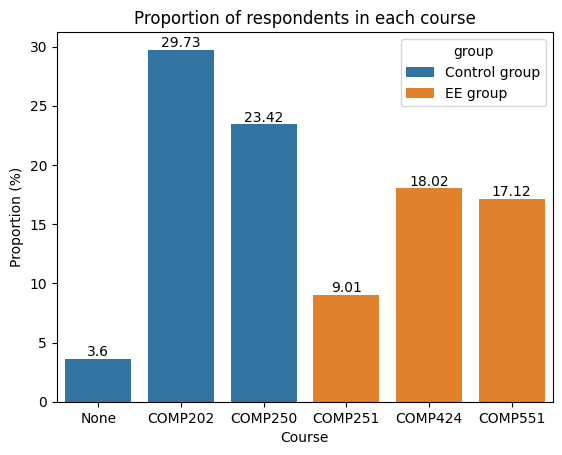

In [115]:
ax = sns.barplot(
    data=n_courses_df,
    x="course",
    y="proportion",
    hue="group"   # a column indicating skyblue vs darksalmon category
)

ax.set_title("Proportion of respondents in each course")
ax.set_xlabel("Course")
ax.set_ylabel("Proportion (%)")
for container in ax.containers:
    ax.bar_label(container)

In [47]:
#plt.pie(n_courses_df["count"], labels=n_courses_df["course"], autopct=autopct_format(n_courses_df["count"]))
#plt.title("Number of responses per course")

## Degree
### EE vs CG

In [121]:
counts_deg_ee = ee_data["Degree type"].value_counts().reindex(deg_type, fill_value=0) # reindexing adds the categories with 0 count
counts_deg_cg = cg_data["Degree type"].value_counts().reindex(deg_type, fill_value=0)

print(f"EE course {counts_deg_ee}")
print("-------------")
print(f"CG course {counts_deg_cg}")

EE course Degree type
Undergraduate    48
Graduate          4
Name: count, dtype: int64
-------------
CG course Degree type
Undergraduate    59
Graduate          0
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

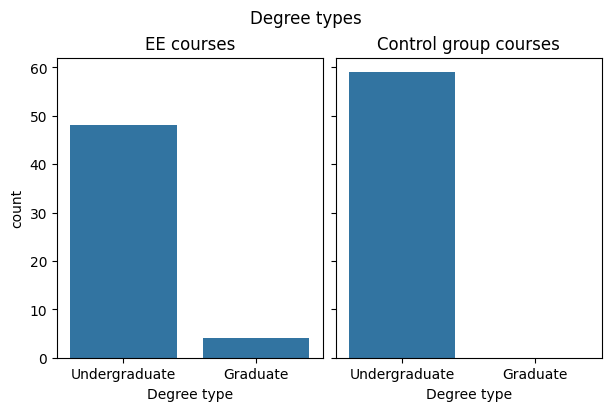

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

sns.countplot(data=ee_data, x="Degree type", ax=ax1, order=deg_type)
sns.countplot(data=cg_data, x="Degree type", ax=ax2, order=deg_type)

fig.suptitle("Degree types")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

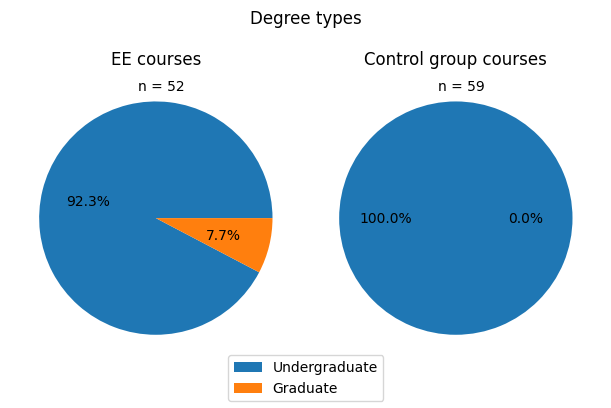

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_deg_ee.values, autopct='%.1f%%')
ax2.pie(counts_deg_cg.values, autopct='%.1f%%')

fig.suptitle("Degree types")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.15, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(deg_type, loc='lower center')

### Degree type per course

In [52]:
counts_deg_courses = {}
for course in course_data:
    counts_deg_courses[course] = course_data[course]["Degree type"].value_counts().reindex(deg_type, fill_value=0)

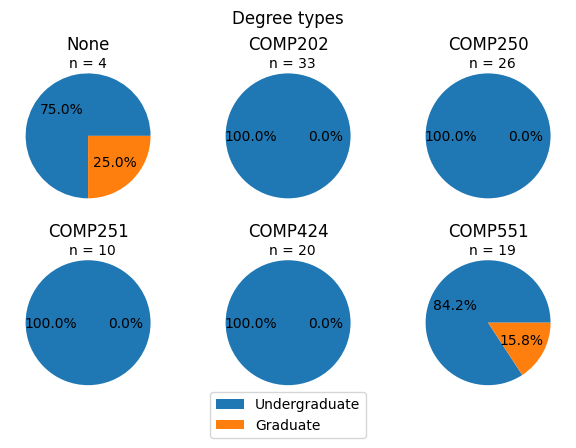

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_deg_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Degree types")
fig.legend(deg_type, loc='lower center', bbox_to_anchor=(0.5, -0.1))

## Year

#### EE vs CG

In [55]:
counts_year_ee = ee_data["Year"].value_counts().reindex(years, fill_value=0) # reindexing adds the categories with 0 count
counts_year_cg = cg_data["Year"].value_counts().reindex(years, fill_value=0)

print(f"EE course {counts_year_ee}")
print("-------------")
print(f"CG course {counts_year_cg}")

EE course Year
U0        0
U1        1
U2       12
U3       23
U4+      12
M1        2
M2        0
M3+       0
PhD1      0
PhD2      0
PhD3      1
PhD4      0
PhD5+     1
Name: count, dtype: int64
-------------
CG course Year
U0        9
U1       39
U2        7
U3        4
U4+       0
M1        0
M2        0
M3+       0
PhD1      0
PhD2      0
PhD3      0
PhD4      0
PhD5+     0
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

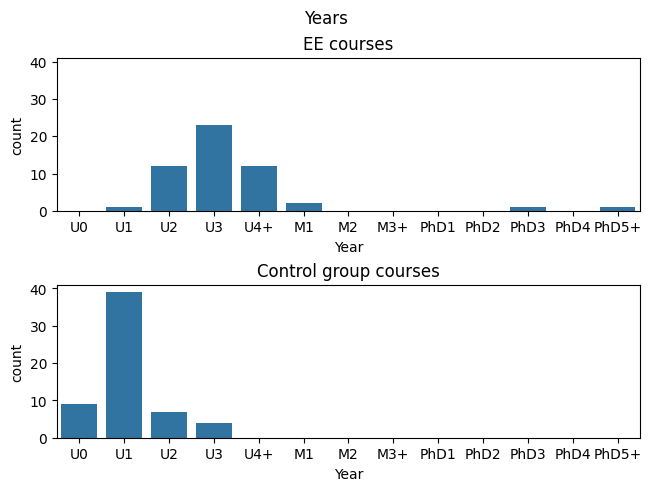

In [122]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True) # draw two plots in one row, two columns

sns.countplot(data=ee_data, x="Year", ax=ax1, order=years)
sns.countplot(data=cg_data, x="Year", ax=ax2, order=years)

fig.suptitle("Years")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

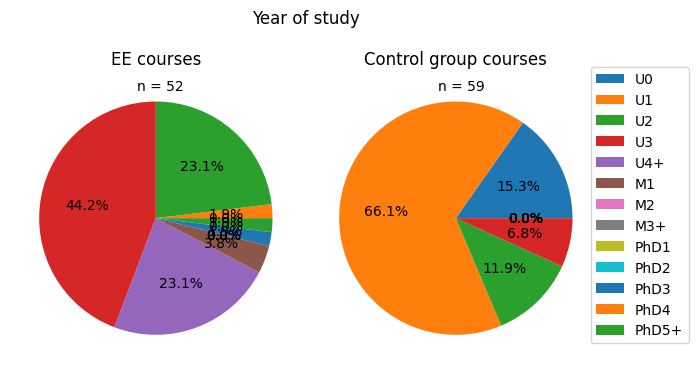

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_year_ee.values, autopct='%.1f%%')
ax2.pie(counts_year_cg.values, autopct='%.1f%%')

fig.suptitle("Year of study")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(years, loc='center right', bbox_to_anchor=(1.15, 0.5))

### Year per course

In [58]:
counts_year_courses = {}
for course in course_data:
    counts_year_courses[course] = course_data[course]["Year"].value_counts().reindex(years, fill_value=0)

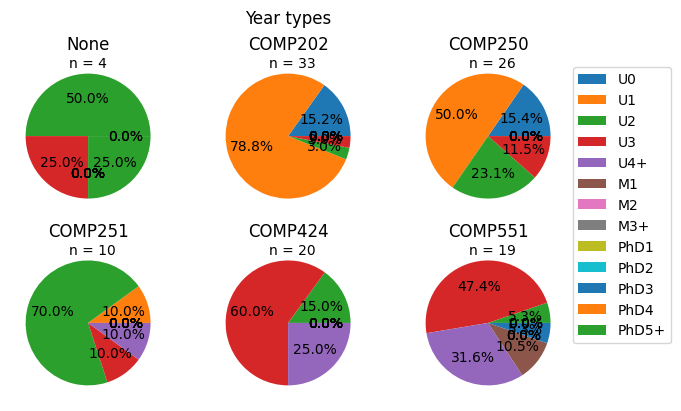

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_year_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Year types")
fig.legend(years, loc='center right', bbox_to_anchor=(1.15, 0.5))

## Major
#### EE vs CG

In [60]:
counts_major_ee_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [ee_data["Field"]["CS/SWE major"].sum(), ee_data["Field"]["CS/SWE minor"].sum(), ee_data["Field"]["Other"].sum()]}
                        
counts_major_cg_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [cg_data["Field"]["CS/SWE major"].sum(), cg_data["Field"]["CS/SWE minor"].sum(), cg_data["Field"]["Other"].sum()]}

counts_major_ee = pd.DataFrame(data=counts_major_ee_dict)
counts_major_cg = pd.DataFrame(data=counts_major_cg_dict)

In [61]:
print(f"EE course \n{counts_major_ee}")
print("-------------")
print(f"CG course \n{counts_major_cg}")

EE course 
          Field  count
0  CS/SWE major     42
1  CS/SWE minor      4
2         Other     17
-------------
CG course 
          Field  count
0  CS/SWE major     24
1  CS/SWE minor      9
2         Other     38


Text(0.5, 1.0, 'Control group courses')

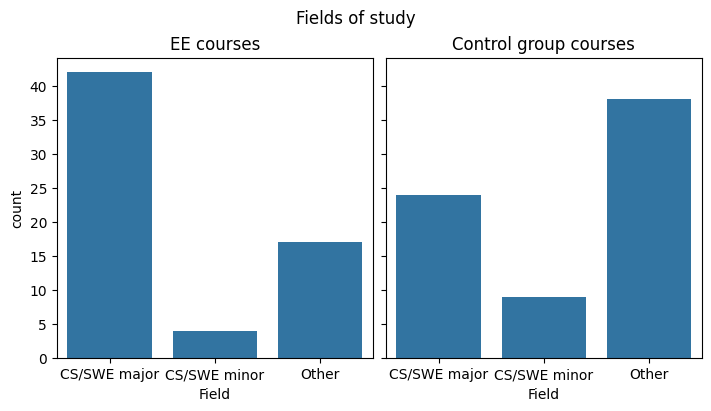

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(7, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

sns.barplot(data=counts_major_ee, x="Field", y="count", ax=ax1)
sns.barplot(data=counts_major_cg, x="Field", y="count", ax=ax2)

fig.suptitle("Fields of study")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

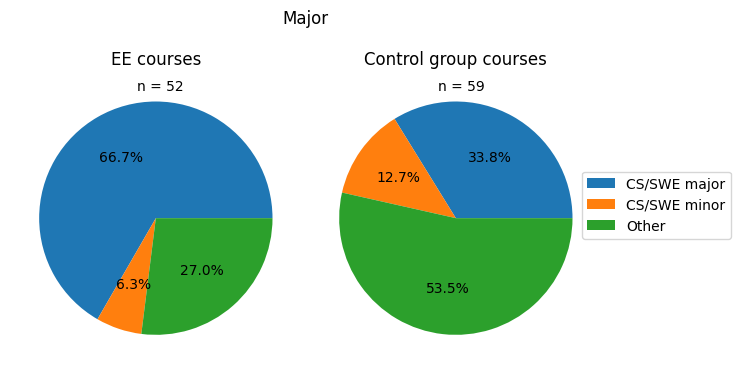

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_major_ee["count"], autopct='%.1f%%')
ax2.pie(counts_major_cg["count"], autopct='%.1f%%')

fig.suptitle("Major")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(majors, loc='center right', bbox_to_anchor=(1.22, 0.5))

### Major per course

In [64]:
counts_major_course = {}
for course in course_data:

    counts_major_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [course_data[course]["Field"]["CS/SWE major"].sum(), course_data[course]["Field"]["CS/SWE minor"].sum(), course_data[course]["Field"]["Other"].sum()]}
                            

    counts_major_course[course] = pd.DataFrame(data=counts_major_dict)

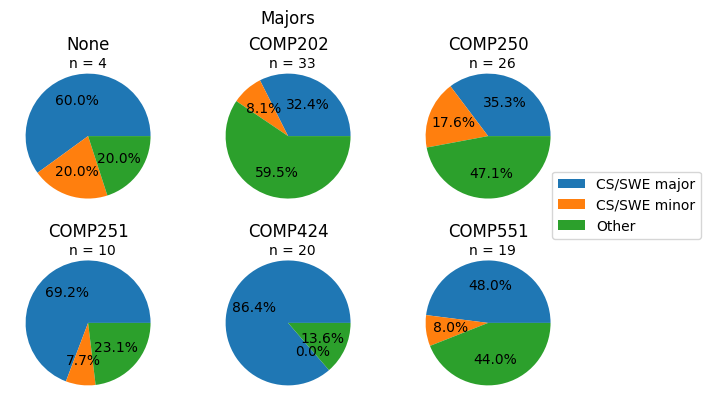

In [65]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_major_course[course]["count"], autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Majors")
fig.legend(majors, loc='center right', bbox_to_anchor=(1.2, 0.5))

## Gender
#### EE vs CG

In [67]:
counts_gender_ee = ee_data["Gender"].value_counts().reindex(genders, fill_value=0)
counts_gender_cg = cg_data["Gender"].value_counts().reindex(genders, fill_value=0)

print(f"EE course {counts_gender_ee}")
print("-------------")
print(f"CG course {counts_gender_cg}")

EE course Gender
Man                     28
Woman                   23
Other                    0
Prefer not to answer     1
Name: count, dtype: int64
-------------
CG course Gender
Man                     18
Woman                   38
Other                    0
Prefer not to answer     3
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

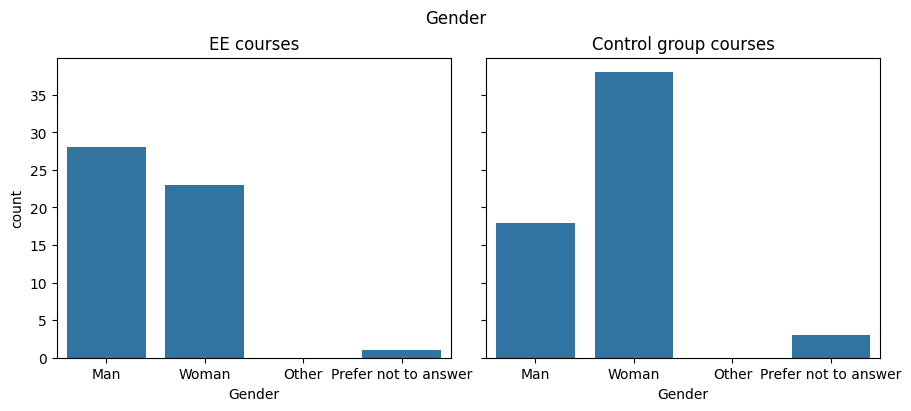

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

sns.countplot(data=ee_data, x="Gender", ax=ax1, order=genders)
sns.countplot(data=cg_data, x="Gender", ax=ax2, order=genders)

fig.suptitle("Gender")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

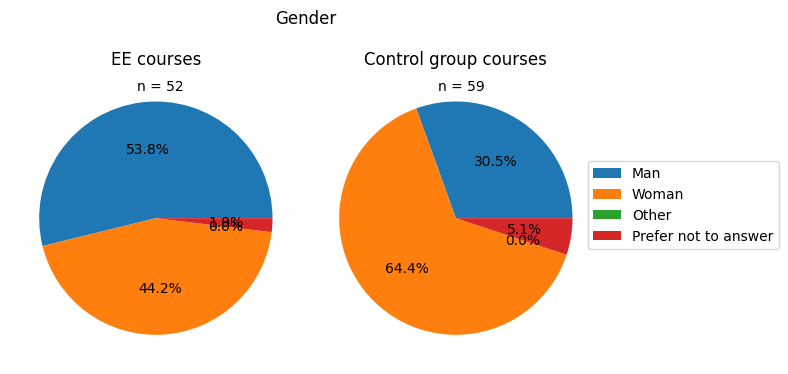

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_gender_ee.values, autopct='%.1f%%')
ax2.pie(counts_gender_cg.values, autopct='%.1f%%')

fig.suptitle("Gender")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(genders, loc='center right', bbox_to_anchor=(1.30, 0.5))

### Gender per course

In [70]:
counts_gender_courses = {}
for course in course_data:
    counts_gender_courses[course] = course_data[course]["Gender"].value_counts().reindex(genders, fill_value=0)

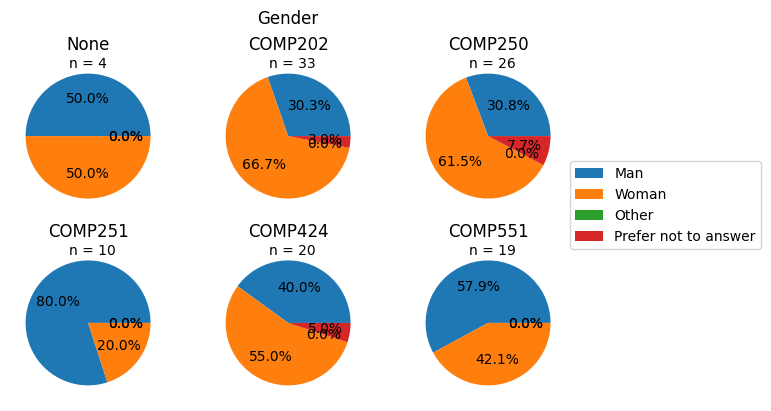

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_gender_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Gender")
fig.legend(genders, loc='center right', bbox_to_anchor=(1.3, 0.5))

## Visible minority
#### EE vs CG

In [73]:
counts_minority_ee = ee_data["Visible minority"].value_counts().reindex(minorities, fill_value=0)
counts_minority_cg = cg_data["Visible minority"].value_counts().reindex(minorities, fill_value=0)

print(f"EE course {counts_minority_ee}")
print("-------------")
print(f"CG course {counts_minority_cg}")

EE course Visible minority
Yes                     30
No                      21
Prefer not to answer     1
Name: count, dtype: int64
-------------
CG course Visible minority
Yes                     26
No                      29
Prefer not to answer     4
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

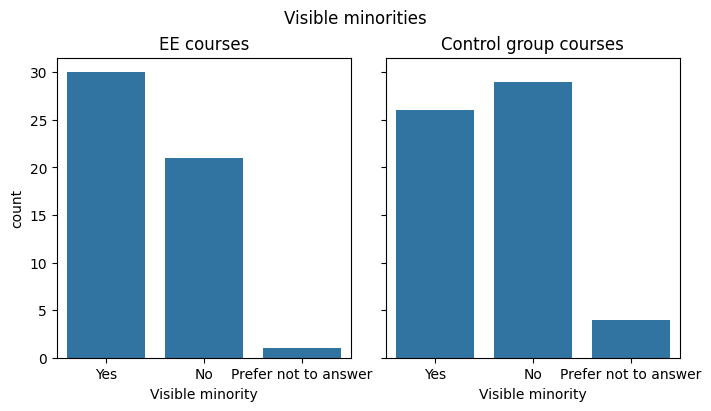

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

sns.countplot(data=ee_data, x="Visible minority", ax=ax1, order=minorities)
sns.countplot(data=cg_data, x="Visible minority", ax=ax2, order=minorities)

fig.suptitle("Visible minorities")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

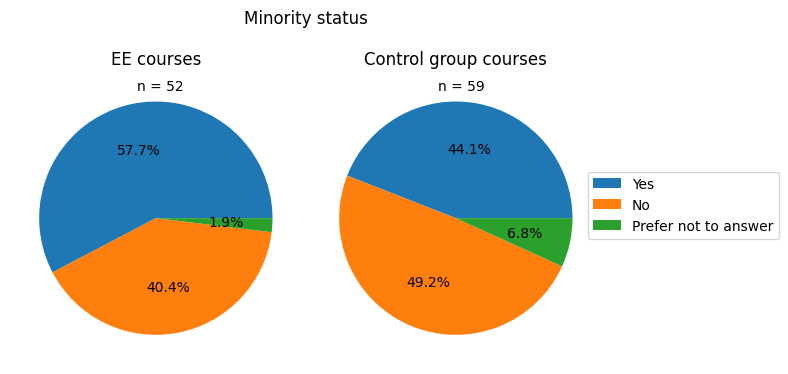

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_minority_ee.values, autopct='%.1f%%')
ax2.pie(counts_minority_cg.values, autopct='%.1f%%')

fig.suptitle("Minority status")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(minorities, loc='center right', bbox_to_anchor=(1.30, 0.5))

### Visible minority per course

In [76]:
counts_minority_courses = {}
for course in course_data:
    counts_minority_courses[course] = course_data[course]["Visible minority"].value_counts().reindex(minorities, fill_value=0)

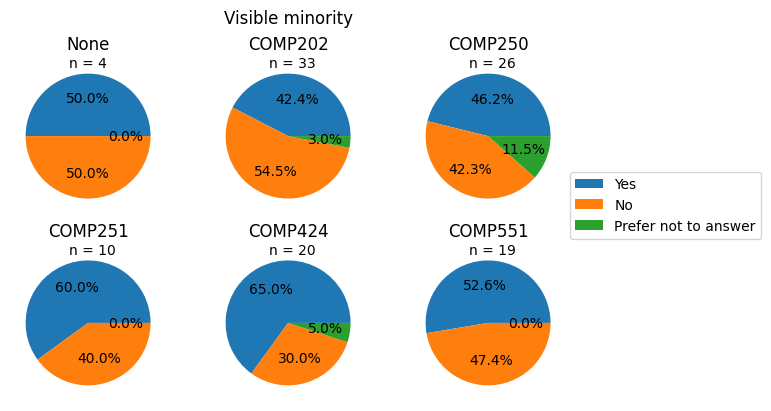

In [77]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_minority_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Visible minority")
fig.legend(minorities, loc='center right', bbox_to_anchor=(1.3, 0.5))

## Age
#### EE vs CG

In [79]:
counts_age_ee = ee_data["Age"].value_counts().reindex(age, fill_value=0)
counts_age_cg = cg_data["Age"].value_counts().reindex(age, fill_value=0)

print(f"EE course {counts_age_ee}")
print("-------------")
print(f"CG course {counts_age_cg}")

EE course Age
<18                      0
18-24                   49
25-34                    2
35-44                    0
>45                      0
Prefer not to answer     1
Name: count, dtype: int64
-------------
CG course Age
<18                      0
18-24                   59
25-34                    0
35-44                    0
>45                      0
Prefer not to answer     0
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

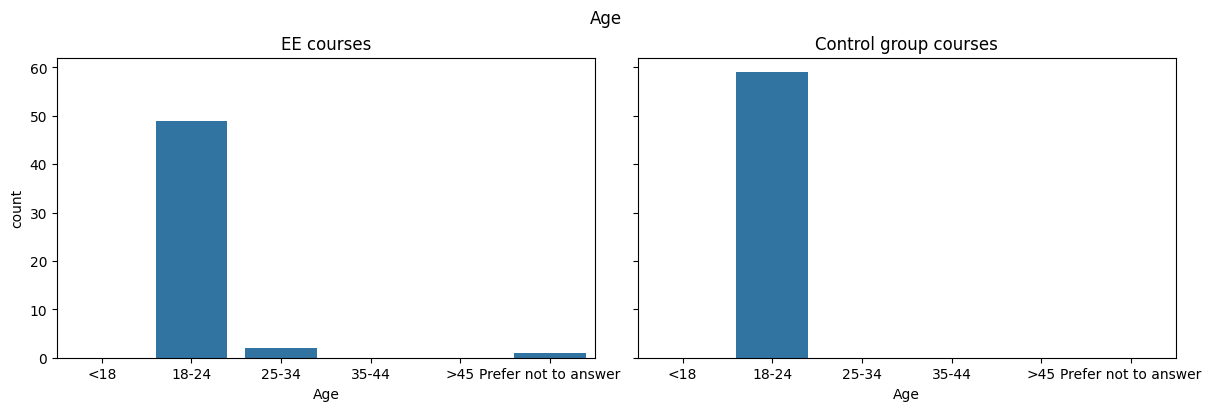

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

sns.countplot(data=ee_data, x="Age", ax=ax1, order=age)
sns.countplot(data=cg_data, x="Age", ax=ax2, order=age)

fig.suptitle("Age")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

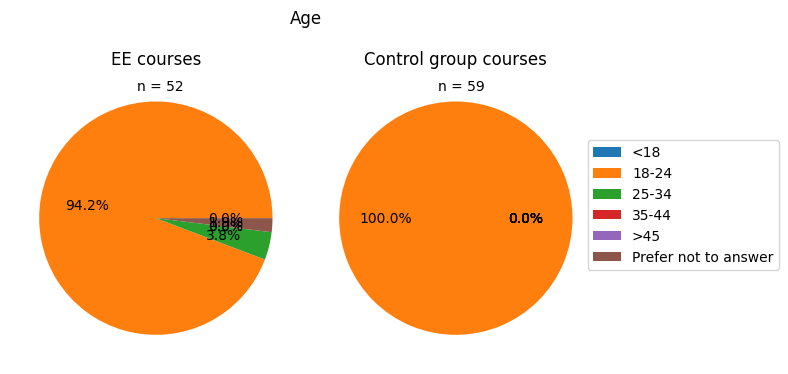

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_age_ee.values, autopct='%.1f%%')
ax2.pie(counts_age_cg.values, autopct='%.1f%%')

fig.suptitle("Age")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(age, loc='center right', bbox_to_anchor=(1.30, 0.5))

### Age per course


In [82]:
counts_age_courses = {}
for course in course_data:
    counts_age_courses[course] = course_data[course]["Age"].value_counts().reindex(age, fill_value=0)

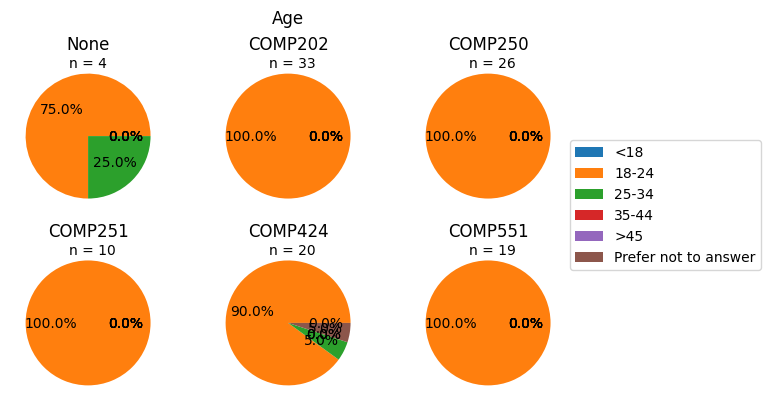

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_age_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Age")
fig.legend(age, loc='center right', bbox_to_anchor=(1.3, 0.5))

## Ethics experience
### EE vs CG

In [85]:
counts_ethics_ee = ee_data["Ethics experience"].value_counts().reindex(ethics_knowledge, fill_value=0)
counts_ethics_cg = cg_data["Ethics experience"].value_counts().reindex(ethics_knowledge, fill_value=0)
print(f"EE course {counts_ethics_ee}")
print("-------------")
print(f"CG course {counts_ethics_cg}")

EE course Ethics experience
Yes    23
No     29
Name: count, dtype: int64
-------------
CG course Ethics experience
Yes    23
No     36
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

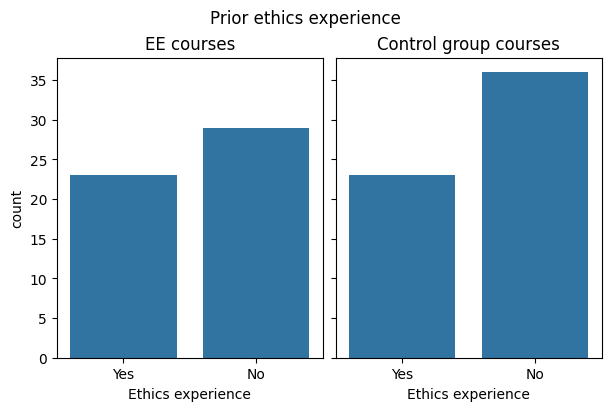

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

sns.countplot(data=ee_data, x="Ethics experience", ax=ax1, order=ethics_knowledge)
sns.countplot(data=cg_data, x="Ethics experience", ax=ax2, order=ethics_knowledge)

fig.suptitle("Prior ethics experience")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

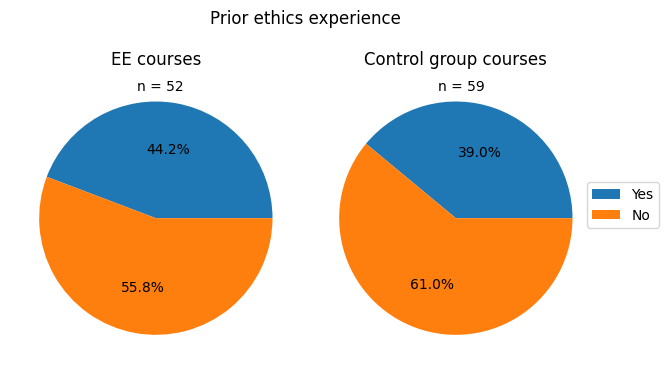

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_ethics_ee.values, autopct='%.1f%%')
ax2.pie(counts_ethics_cg.values, autopct='%.1f%%')

fig.suptitle("Prior ethics experience")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(ethics_knowledge, loc='center right', bbox_to_anchor=(1.1, 0.5))

### Prior ethics experience per course

In [88]:
counts_ethics_courses = {}
for course in course_data:
    counts_ethics_courses[course] = course_data[course]["Ethics experience"].value_counts().reindex(ethics_knowledge, fill_value=0)

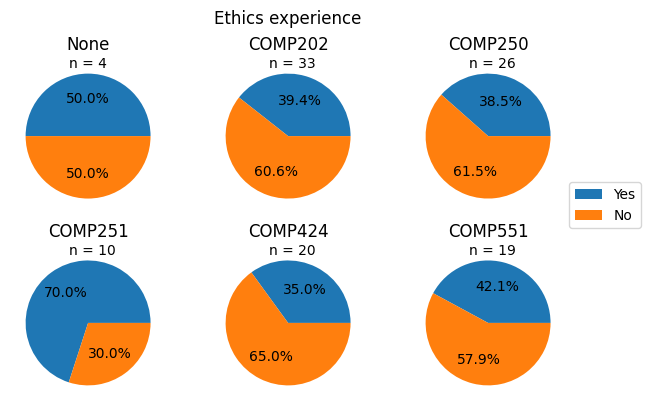

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_ethics_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Ethics experience")
fig.legend(ethics_knowledge, loc='center right', bbox_to_anchor=(1.1, 0.5))

## Career questions
### EE vs CG

c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:310: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  responses_to_first_question = responses_per_question[0]
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_l

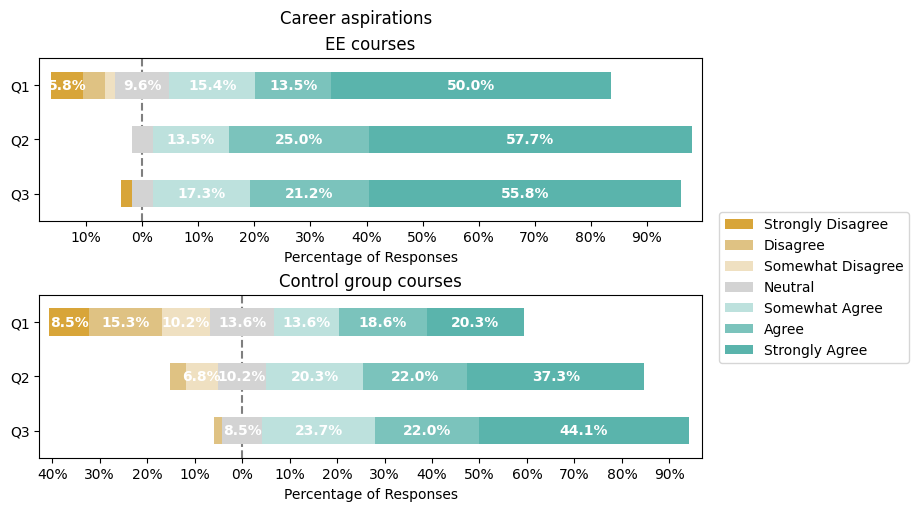

In [153]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

plot_likert.plot_likert(ee_data["Career"], likert, plot_percentage=True, colors=plot_likert.colors.likert7, bar_labels=True, ax=ax1, legend=False)
plot_likert.plot_likert(cg_data["Career"], likert, plot_percentage=True, colors=plot_likert.colors.likert7, bar_labels=True, ax=ax2, legend=False)

fig.suptitle("Career aspirations")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

'''
ax1.set_yticklabels(["I plan to pursue a career in computer \nscience or a closely related \nfield (e.g. software engineering).",
                     "Technical and programming skills \nwill be important in my future career.",
                     "It is important for me to have \na career in which I can make a \npositive impact on society."][::-1])
'''

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, likert_values, bbox_to_anchor=(1.3, 0.6))

### Career questions per course

c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:310: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  responses_to_first_question = responses_per_question[0]
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_l

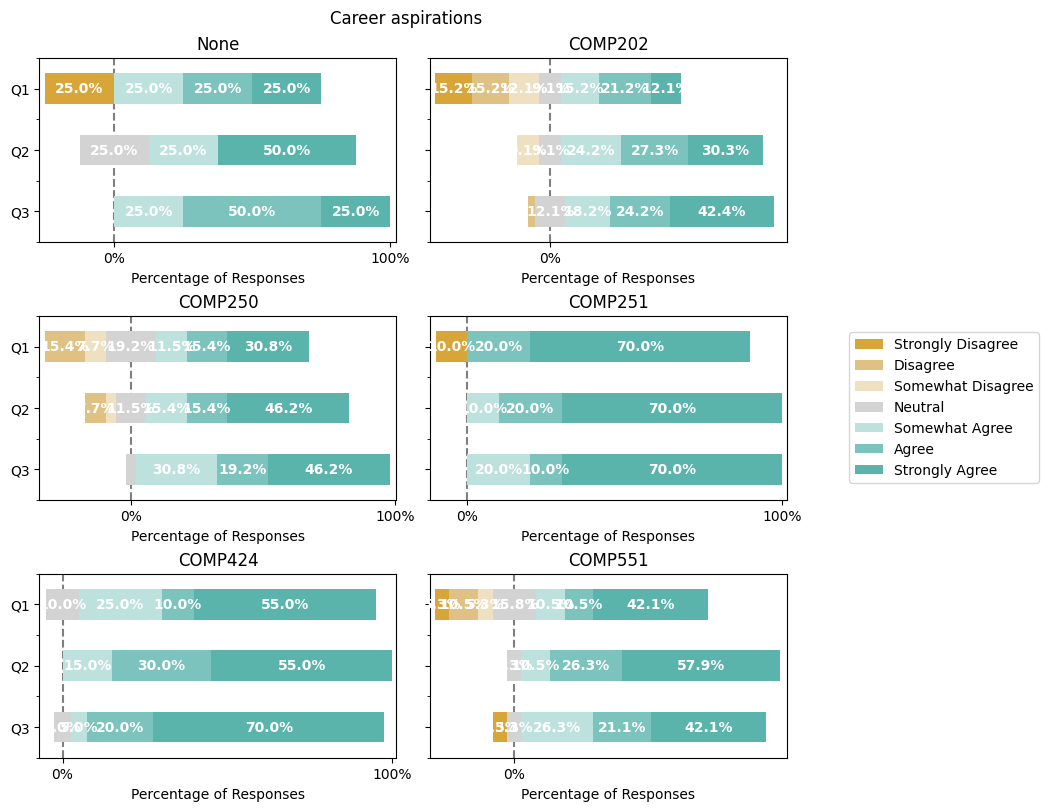

In [158]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    #print(course_data[course]["Career"])
    row, col = i//2, i%2
    plot_likert.plot_likert(course_data[course]["Career"], likert, plot_percentage=True, colors=plot_likert.colors.likert7, ax=axes[row, col], bar_labels=True, legend=False)
    axes[row, col].set_title(course)    

fig.suptitle("Career aspirations")
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, likert_values, bbox_to_anchor=(1.3, 0.6))